In [1]:
import pandas as pd 
import numpy as np 
from scipy.optimize import root 

from grid_model import GridDataClass, GridModel

In [2]:
grid_data = GridDataClass("grid_data3.xlsx", f_nom=50)
grid_model = GridModel(grid_data) 

func = grid_model._setup_pf()

In [3]:
sol = grid_model.powerflow()
sol

P_calc = [ 10.398 -50.     40.      5.     -5.   ] MW 
Q_calc = [  0.362 -20.      4.676  18.692  -2.   ] Mvar 
V_buses = [1.     0.9967 1.     1.02   0.9706] pu 
d_buses = [ 0.     -0.6802 -0.1677 -0.9242 -2.5985] deg 

In [4]:
sol.P_calc

array([ 10.39785418, -50.        ,  40.        ,   5.        ,
        -5.        ])

In [4]:
sol.P_calc

array([ 10.39785418, -50.        ,  40.        ,   5.        ,
        -5.        ])

In [5]:
sol.d_buses*180/np.pi 

array([ 0.        , -0.68015495, -0.16768721, -0.92423472, -2.59850105])

In [6]:
sol.Q_calc

array([  0.36225115, -20.        ,   4.67633458,  18.69198958,
        -2.        ])

In [7]:
sol.V_buses

array([1.        , 0.99669651, 1.        , 1.02      , 0.97060469])

In [4]:
sol.get_P_losses()

0.3978299629296105

In [5]:
%timeit grid_model.powerflow()

669 µs ± 18.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [5]:
grid_data._trafo_data

[BranchDataClass(S_base_mva=90, V_base_kV=132, r_l=0.02250902158676768, x_l=0.1331407994572996, idx_1=1, idx_2=3, g_1=0.00011118652080686351, b_1=-0.0033307349355535983, g_2=0.00011118652080686351, b_2=-0.0033307349355535983, is_pu=True)]

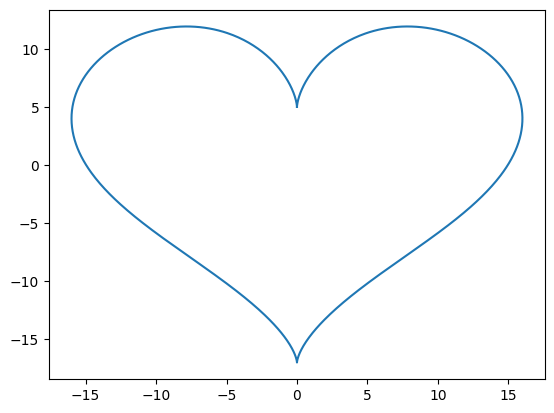

In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
from numpy import cos, sin

t = np.linspace(0, 2*np.pi, 1000)
x_t = 16*sin(t)**3
y_t = 13*cos(t) - 5*cos(2*t) -2*cos(3*t) - cos(4*t)

plt.plot(x_t, y_t, label="x(t)")
# plt.plot(t, y_t, label="y(t)")
# plt.grid() 
# plt.legend() 
plt.show() 